In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

In [2]:
with open(f"../intermediate_files/all_df_no_training_vars.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
with open(f"../training_outputs/first_multiclass_training/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

train_test_merged_df = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")
for prob in ['prob_1gNp', 'prob_1g0p', 'prob_1gNp1mu', 'prob_1g0p1mu', 'prob_1g_outFV', 'prob_2gNp', 'prob_2g0p', 'prob_2gNp1mu', 'prob_2g0p1mu', 'prob_2g_outFV', 'prob_other']:
    train_test_merged_df[prob] = train_test_merged_df[prob].fillna(-1)

merged_df = train_test_merged_df.query("not used_for_training == True")
frac_test = len(merged_df) / len(train_test_merged_df)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")
merged_df["wc_net_weight"] = merged_df["wc_net_weight"] / frac_test

print(f"{merged_df.shape=}")
presel_merged_df = merged_df.query("wc_kine_reco_Enu > 0 and wc_shw_sp_n_20mev_showers > 0")
print(f"{presel_merged_df.shape=}")

presel_merged_df


all_df.shape=(178827, 66)
pred_df.shape=(178827, 16)
weighting up by the fraction of test events: 0.500
merged_df.shape=(89414, 78)
presel_merged_df.shape=(21612, 78)


/var/folders/yg/3cj9svrx2kz3bpv_6thtt7x00000gn/T/ipykernel_34638/124986215.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df["wc_net_weight"] = merged_df["wc_net_weight"] / frac_test


,run,subrun,event,filetype,wc_net_weight,reconstructable_signal_category,physics_signal_category,wc_nue_score,wc_numu_score,wc_nc_delta_score,...,prob_1g0p,prob_1gNp1mu,prob_1g0p1mu,prob_1g_outFV,prob_2gNp,prob_2g0p,prob_2gNp1mu,prob_2g0p1mu,prob_2g_outFV,prob_other
0,20290,30,1510,nc_pi0_overlay,0.853007,2gNp,NC1pi0_Np,-15.000000,-0.445759,-3.342609,...,0.001358,5.078772e-05,0.000002,0.000011,0.918550,0.011597,0.009078,0.000432,0.000004,0.056989
4,20290,30,1543,nc_pi0_overlay,0.853007,2g0p,NC1pi0_0p,-9.779932,-1.000641,-7.236095,...,0.000184,7.324530e-06,0.000003,0.000007,0.031920,0.959128,0.000601,0.000149,0.000053,0.007321
11,20672,75,3777,nc_pi0_overlay,0.853007,2gNp,NC1pi0_Np,-15.000000,-0.516594,-6.828529,...,0.005435,2.355324e-04,0.000011,0.000764,0.755781,0.028913,0.007463,0.003299,0.000032,0.146710
12,20672,75,3778,nc_pi0_overlay,0.853007,1gNp,NC1pi0_Np,-5.482184,-0.449370,-3.514264,...,0.000216,6.713180e-06,0.000004,0.000057,0.063256,0.000550,0.000008,0.000001,0.000123,0.888266
20,20672,79,3981,nc_pi0_overlay,0.853007,2gNp,NC1pi0_Np,-15.000000,0.639657,-3.551029,...,0.000209,9.027039e-05,0.000004,0.000123,0.565202,0.014870,0.008209,0.000051,0.000014,0.408879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178134,20049,349,17466,dirt_overlay,15.895428,other,other,-15.000000,-0.368430,-1.768165,...,0.021135,2.093759e-05,0.000006,0.007101,0.012123,0.003365,0.000530,0.000034,0.000009,0.951364
178178,20040,36,1838,dirt_overlay,19.528940,other,other,-15.000000,-2.073247,-2.908311,...,0.002619,9.434036e-07,0.000003,0.000489,0.006360,0.020392,0.000007,0.000146,0.017109,0.949436
178258,20041,323,16168,dirt_overlay,18.884352,other,other,-11.140122,0.178250,-6.237562,...,0.000193,4.383488e-05,0.000003,0.000627,0.025798,0.002722,0.000333,0.000016,0.000024,0.735299
178315,20059,98,4942,dirt_overlay,15.895428,other,other,-15.000000,-2.330076,-2.802451,...,0.004204,2.209032e-04,0.000002,0.003373,0.001916,0.011491,0.000249,0.000015,0.000010,0.977901


# 1g and 2g

  0%|          | 0/11 [00:00<?, ?it/s]

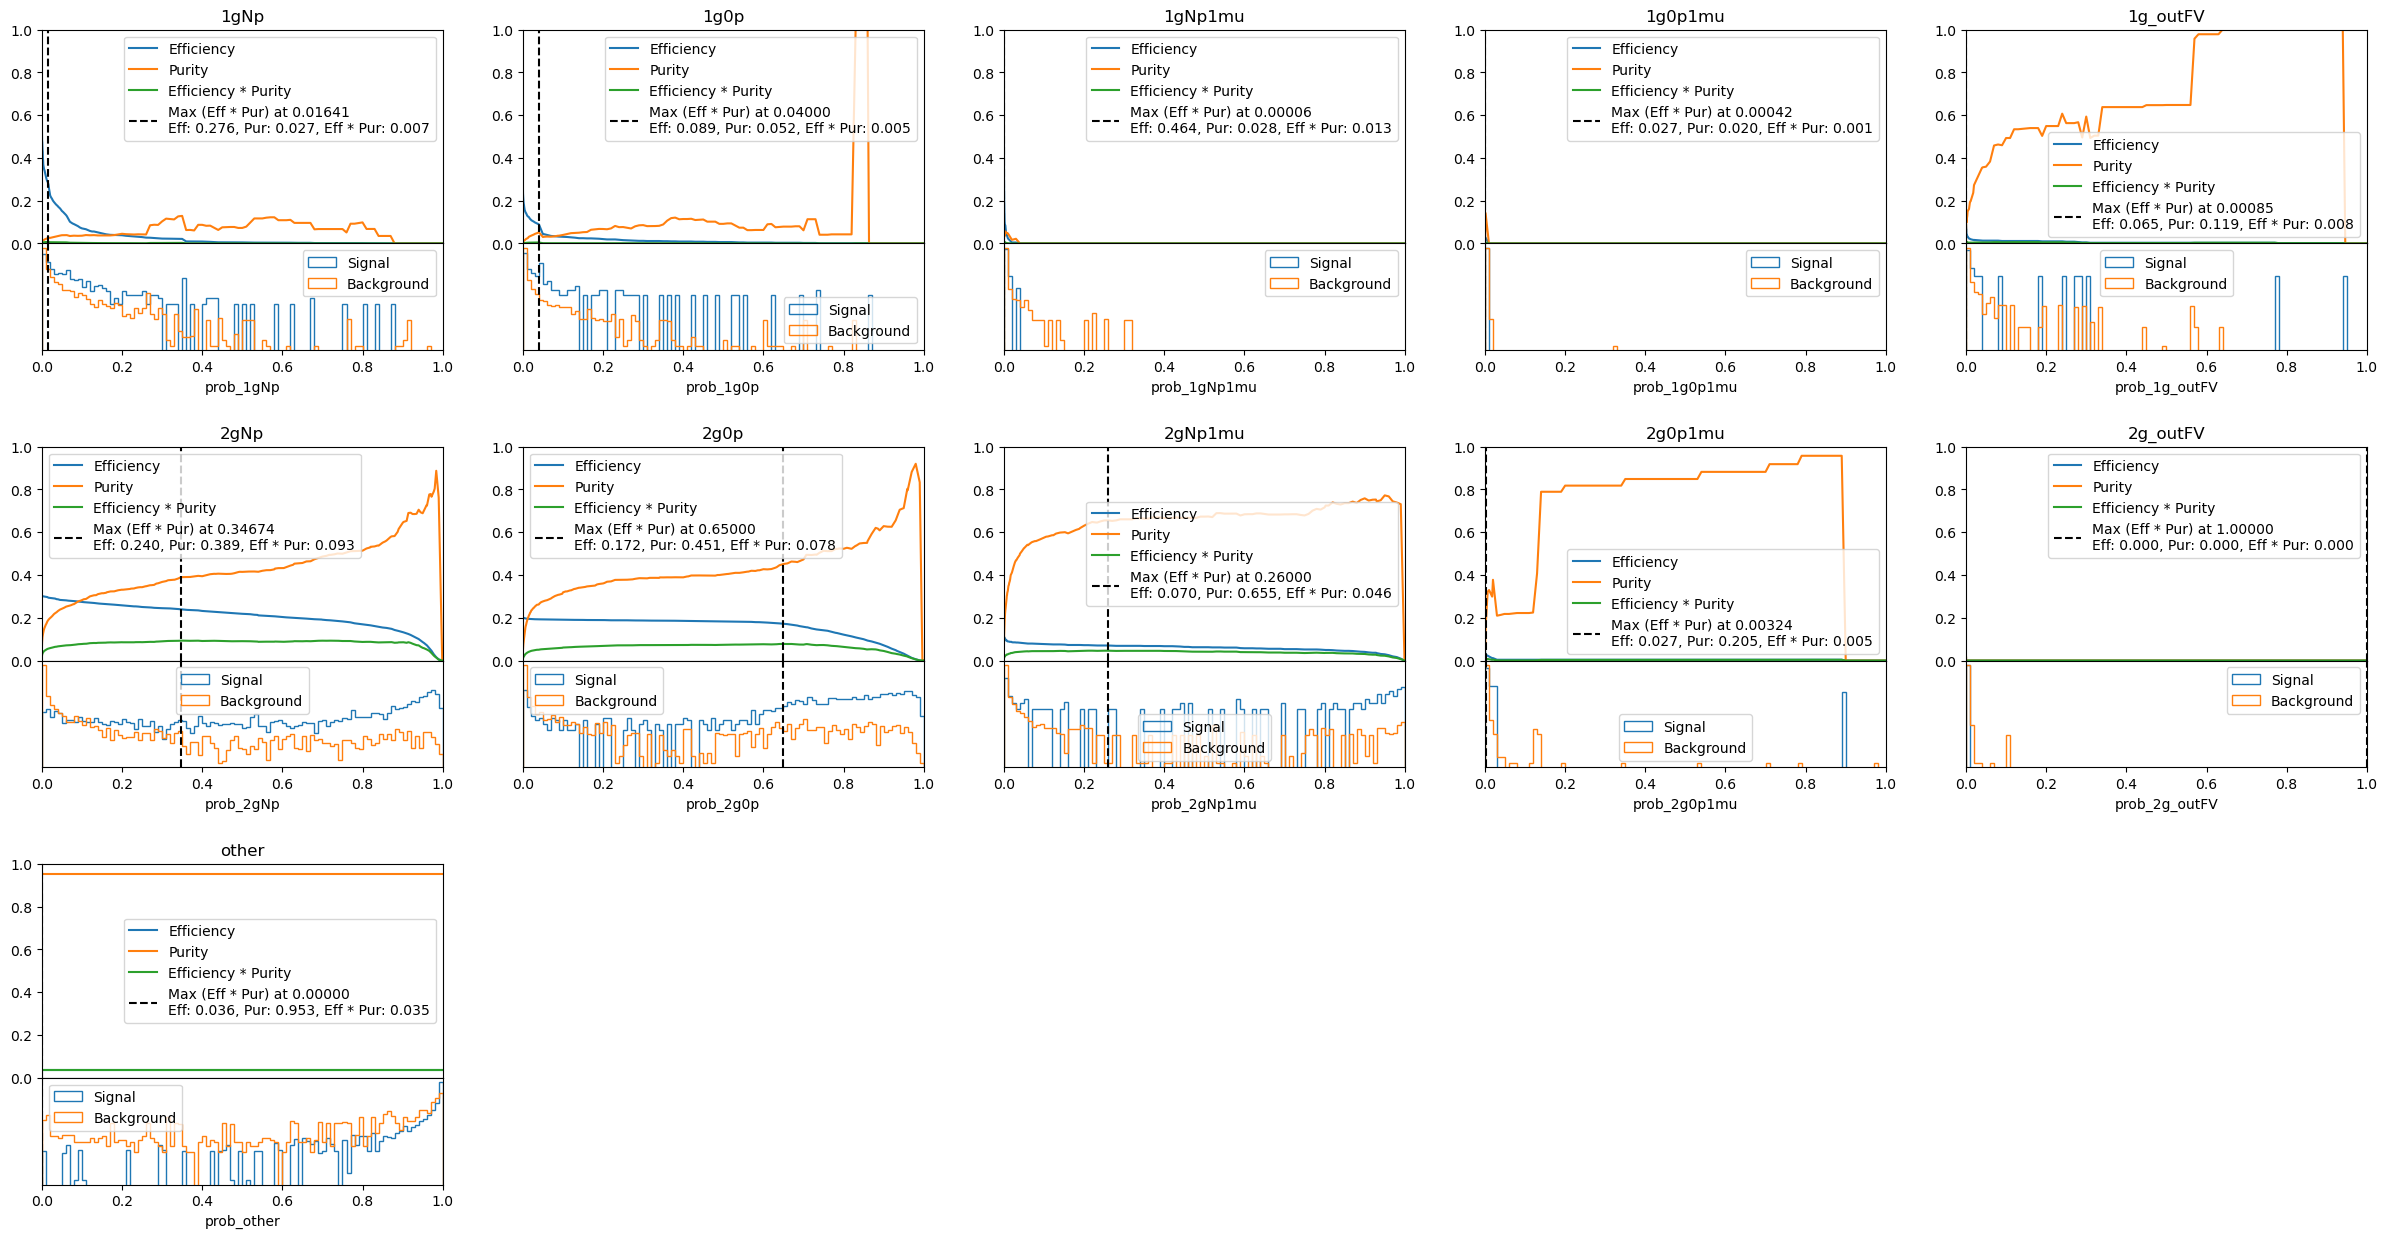

In [3]:
weights = merged_df["wc_net_weight"].to_numpy()
presel_mask = (merged_df["wc_kine_reco_Enu"] > 0) & (merged_df["wc_shw_sp_n_20mev_showers"] > 0)
sig_categories = merged_df["reconstructable_signal_category"].to_numpy()

already_selected_mask = np.zeros(merged_df.shape[0], dtype=bool)

plt.rcParams['font.size'] = 10
fig = plt.figure(figsize=(30, 15))

all_cutoffs = []

prob_types = ['prob_1gNp', 'prob_1g0p', 'prob_1gNp1mu', 'prob_1g0p1mu', 'prob_1g_outFV', 'prob_2gNp', 'prob_2g0p', 'prob_2gNp1mu', 'prob_2g0p1mu', 'prob_2g_outFV', 'prob_other']

for i in tqdm(range(len(prob_types))):
    prob = prob_types[i]

    signal_category = prob[5:]
    probabilities = merged_df[prob].to_numpy()
    total_sig = weights[sig_categories == signal_category].sum()

    max_eff = 0
    max_pur = 0
    max_eff_times_pur = 0
    max_eff_times_pur_cutoff = 1 # default to no selection

    all_eff = []
    all_pur = []
    all_eff_times_pur = []

    uniform_test_cutoff_points = np.linspace(0, 1, 101)
    quantile_test_cutoff_points = np.quantile(probabilities[presel_mask], np.linspace(0, 1, 101))
    test_cutoff_points = np.sort(np.concatenate([uniform_test_cutoff_points, quantile_test_cutoff_points]))

    for cutoff in test_cutoff_points:

        if signal_category == 'other':
            cutoff = 0

        sig_sel = weights[(sig_categories == prob[5:]) & presel_mask & (probabilities > cutoff) & (~already_selected_mask)].sum()
        bkg_sel = weights[(sig_categories != prob[5:]) & presel_mask & (probabilities > cutoff) & (~already_selected_mask)].sum()

        eff = sig_sel / total_sig
        if sig_sel + bkg_sel > 0:
            pur = sig_sel / (sig_sel + bkg_sel)
        else:
            pur = 0
        eff_times_pur = eff * pur

        all_eff.append(eff)
        all_pur.append(pur)
        all_eff_times_pur.append(eff_times_pur)

        num_sel_events = len(weights[presel_mask & (probabilities > cutoff) & (~already_selected_mask)])

        if eff_times_pur > max_eff_times_pur and pur > 0.02 and num_sel_events > 50: # only allow a selection with reasonable purity and enough MC stats
            max_eff = eff
            max_pur = pur
            max_eff_times_pur = eff_times_pur
            max_eff_times_pur_cutoff = cutoff

        if signal_category == 'other':
            continue


    gs = fig.add_gridspec(3, 5, hspace=0.3, wspace=0.2)
    row = i // 5
    col = i % 5
    
    # Create nested gridspec for the two panels
    nested_gs = gs[row, col].subgridspec(2, 1, height_ratios=[2, 1], hspace=0)
    
    ax1 = fig.add_subplot(nested_gs[0])
    ax2 = fig.add_subplot(nested_gs[1])

    # Upper panel - metrics vs cutoff
    ax1.plot(test_cutoff_points, all_eff, label="Efficiency")
    ax1.plot(test_cutoff_points, all_pur, label="Purity")
    ax1.plot(test_cutoff_points, all_eff_times_pur, label="Efficiency * Purity")
    ax1.axvline(x=max_eff_times_pur_cutoff, color="k", linestyle='--', label=f"Max (Eff * Pur) at {max_eff_times_pur_cutoff:.5f}\nEff: {max_eff:.3f}, Pur: {max_pur:.3f}, Eff * Pur: {max_eff_times_pur:.3f}")
    ax1.legend()
    ax1.set_title(f"{signal_category}")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xticks([])

    # Lower panel - probability distributions
    sig_mask = (sig_categories == signal_category) & (~already_selected_mask)
    bkg_mask = ~sig_mask & (~already_selected_mask)
    
    sig_probs = probabilities[sig_mask & presel_mask & (probabilities > 0)]
    bkg_probs = probabilities[bkg_mask & presel_mask & (probabilities > 0)]
    sig_weights = weights[sig_mask & presel_mask & (probabilities > 0)]
    bkg_weights = weights[bkg_mask & presel_mask & (probabilities > 0)]

    bins = np.linspace(0, 1, 101)
    ax2.hist(sig_probs, bins=bins, weights=sig_weights, histtype='step', label='Signal', density=True)
    ax2.hist(bkg_probs, bins=bins, weights=bkg_weights, histtype='step', label='Background', density=True)
    ax2.axvline(x=max_eff_times_pur_cutoff, color="k", linestyle='--')
    ax2.legend()
    ax2.set_yscale('log')
    ax2.set_xlabel(prob)
    ax2.set_xlim(0, 1)
    ax2.set_yticks([])

    already_selected_mask[probabilities > max_eff_times_pur_cutoff] = True

    all_cutoffs.append(max_eff_times_pur_cutoff)

plt.show()

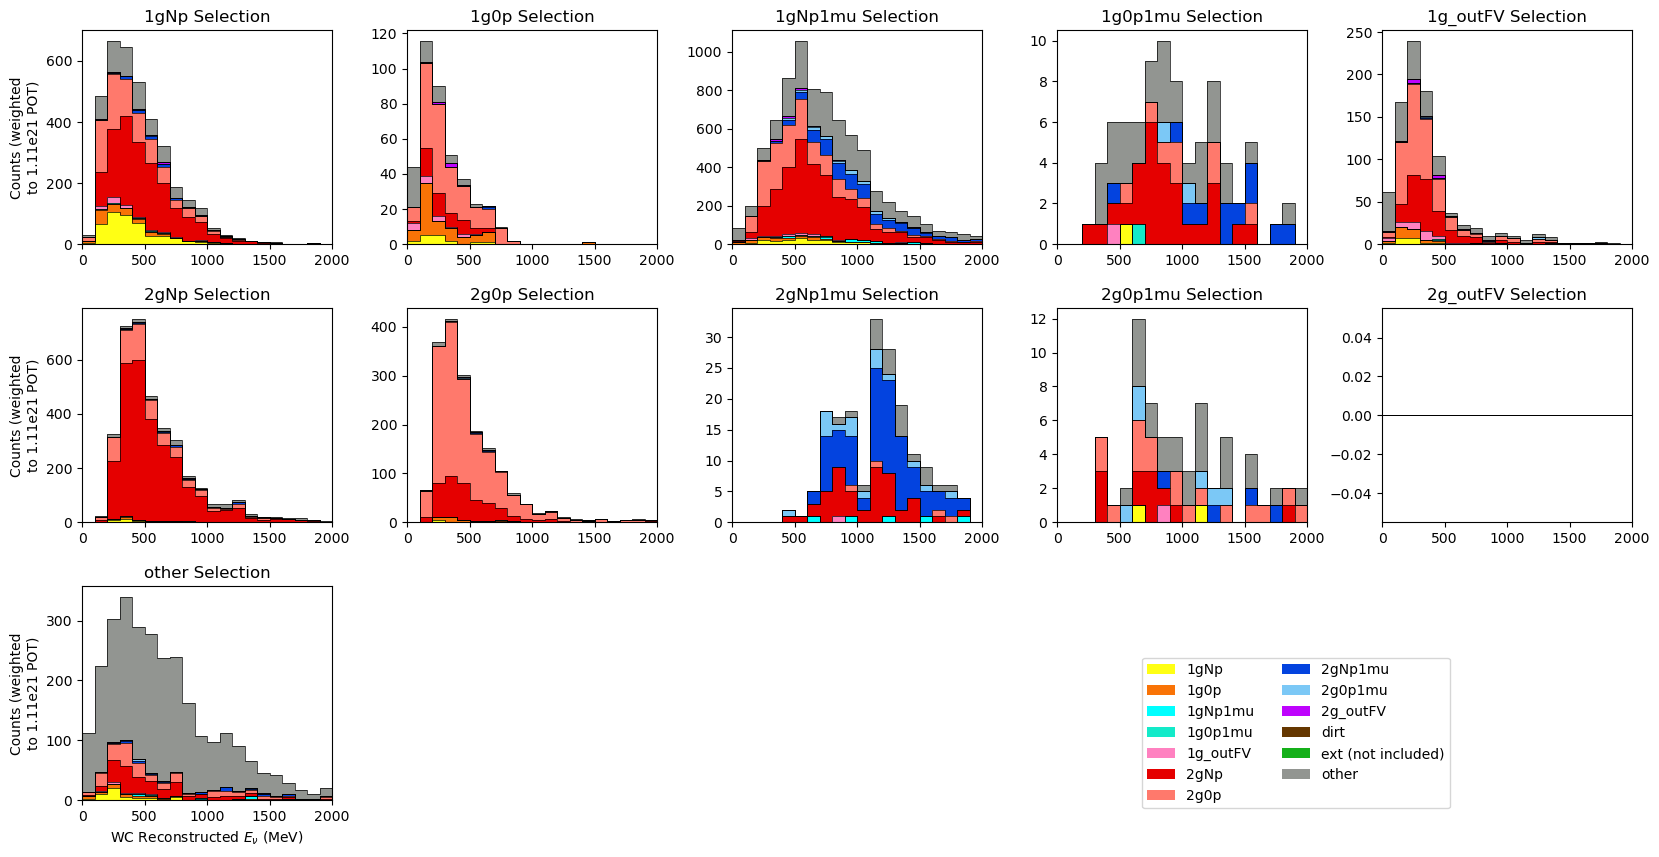

In [4]:
simple_queries = []
for i, signal_category in enumerate(['1gNp', '1g0p', '1gNp1mu', '1g0p1mu', '1g_outFV', '2gNp', '2g0p', '2gNp1mu', '2g0p1mu', '2g_outFV', 'other']):
    simple_queries.append(f"prob_{signal_category} > {all_cutoffs[i]:.5f}")

queries = []
for i in range(len(simple_queries)):
    if i == 0:
        queries.append(f"{simple_queries[0]}")
    else:
        queries.append(f"{simple_queries[i]} and {queries[-1].replace('>', '<')}")


breakdown_dic = {
    '1gNp': "xkcd:yellow",
    '1g0p': "xkcd:orange", 
    '1gNp1mu': "xkcd:cyan",
    '1g0p1mu': "xkcd:aqua",
    '1g_outFV': "xkcd:pink",
    '2gNp': "xkcd:red",
    '2g0p': "xkcd:salmon",
    '2gNp1mu': "xkcd:blue",
    '2g0p1mu': "xkcd:lightblue",
    '2g_outFV': "xkcd:bright purple",
    'dirt': "xkcd:brown",
    'ext (not included)': "xkcd:green",
    'other': "xkcd:gray",
}

breakdown_labels = list(breakdown_dic.keys())
colors = list(breakdown_dic.values())

fig, axs = plt.subplots(3, 5, figsize=(20, 10))
axs = axs.flatten()

bins = np.linspace(0, 2000, 21)
bin_centers = (bins[:-1] + bins[1:]) / 2
multi_bin_centers = [bin_centers] * len(breakdown_dic)
outline_colors = ["k"] * len(breakdown_dic)

for i, signal_category in enumerate(['1gNp', '1g0p', '1gNp1mu', '1g0p1mu', '1g_outFV', '2gNp', '2g0p', '2gNp1mu', '2g0p1mu', '2g_outFV', 'other']):

    sel_df = presel_merged_df.query(queries[i])

    counts = []
    for k in breakdown_dic:
        if k == 'dirt':
            curr_df = sel_df.query(f"filetype == 'dirt'")
        elif k == 'ext (not included)':
            curr_df = sel_df.query(f"filetype == 'ext'")
        elif k in ["1gNp", "1g0p", "1gNp1mu", "1g0p1mu", "2gNp", "2g0p", "2gNp1mu", "2g0p1mu", "1g_outFV", "2g_outFV", "other"]:
            curr_df = sel_df.query(f"filetype != 'dirt' and filetype != 'ext' and reconstructable_signal_category == '{k}'")
        else:
            raise ValueError(f"Invalid signal category: {k}")
        counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], bins=bins)[0])

    axs[i].hist(multi_bin_centers, weights=counts, bins=bins, color=colors, stacked=True, label=breakdown_labels)
    axs[i].hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)
    
    if i >= 10: # Only show x-label for bottom row
        axs[i].set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
    if i % 5 == 0: # Only show y-label for leftmost column
        axs[i].set_ylabel("Counts (weighted\nto 1.11e21 POT)")
    axs[i].set_title(f"{signal_category} Selection")
    axs[i].set_xlim(0, 2000)
    
    if i == 10:
        axs[i].legend(ncol=2, loc='upper right', bbox_to_anchor=(5.5, 0.7))

for ax in axs[11:15]:
    ax.remove()

fig.subplots_adjust(hspace=0.3, wspace=0.3)

plt.show()



# 2g Only

  0%|          | 0/6 [00:00<?, ?it/s]

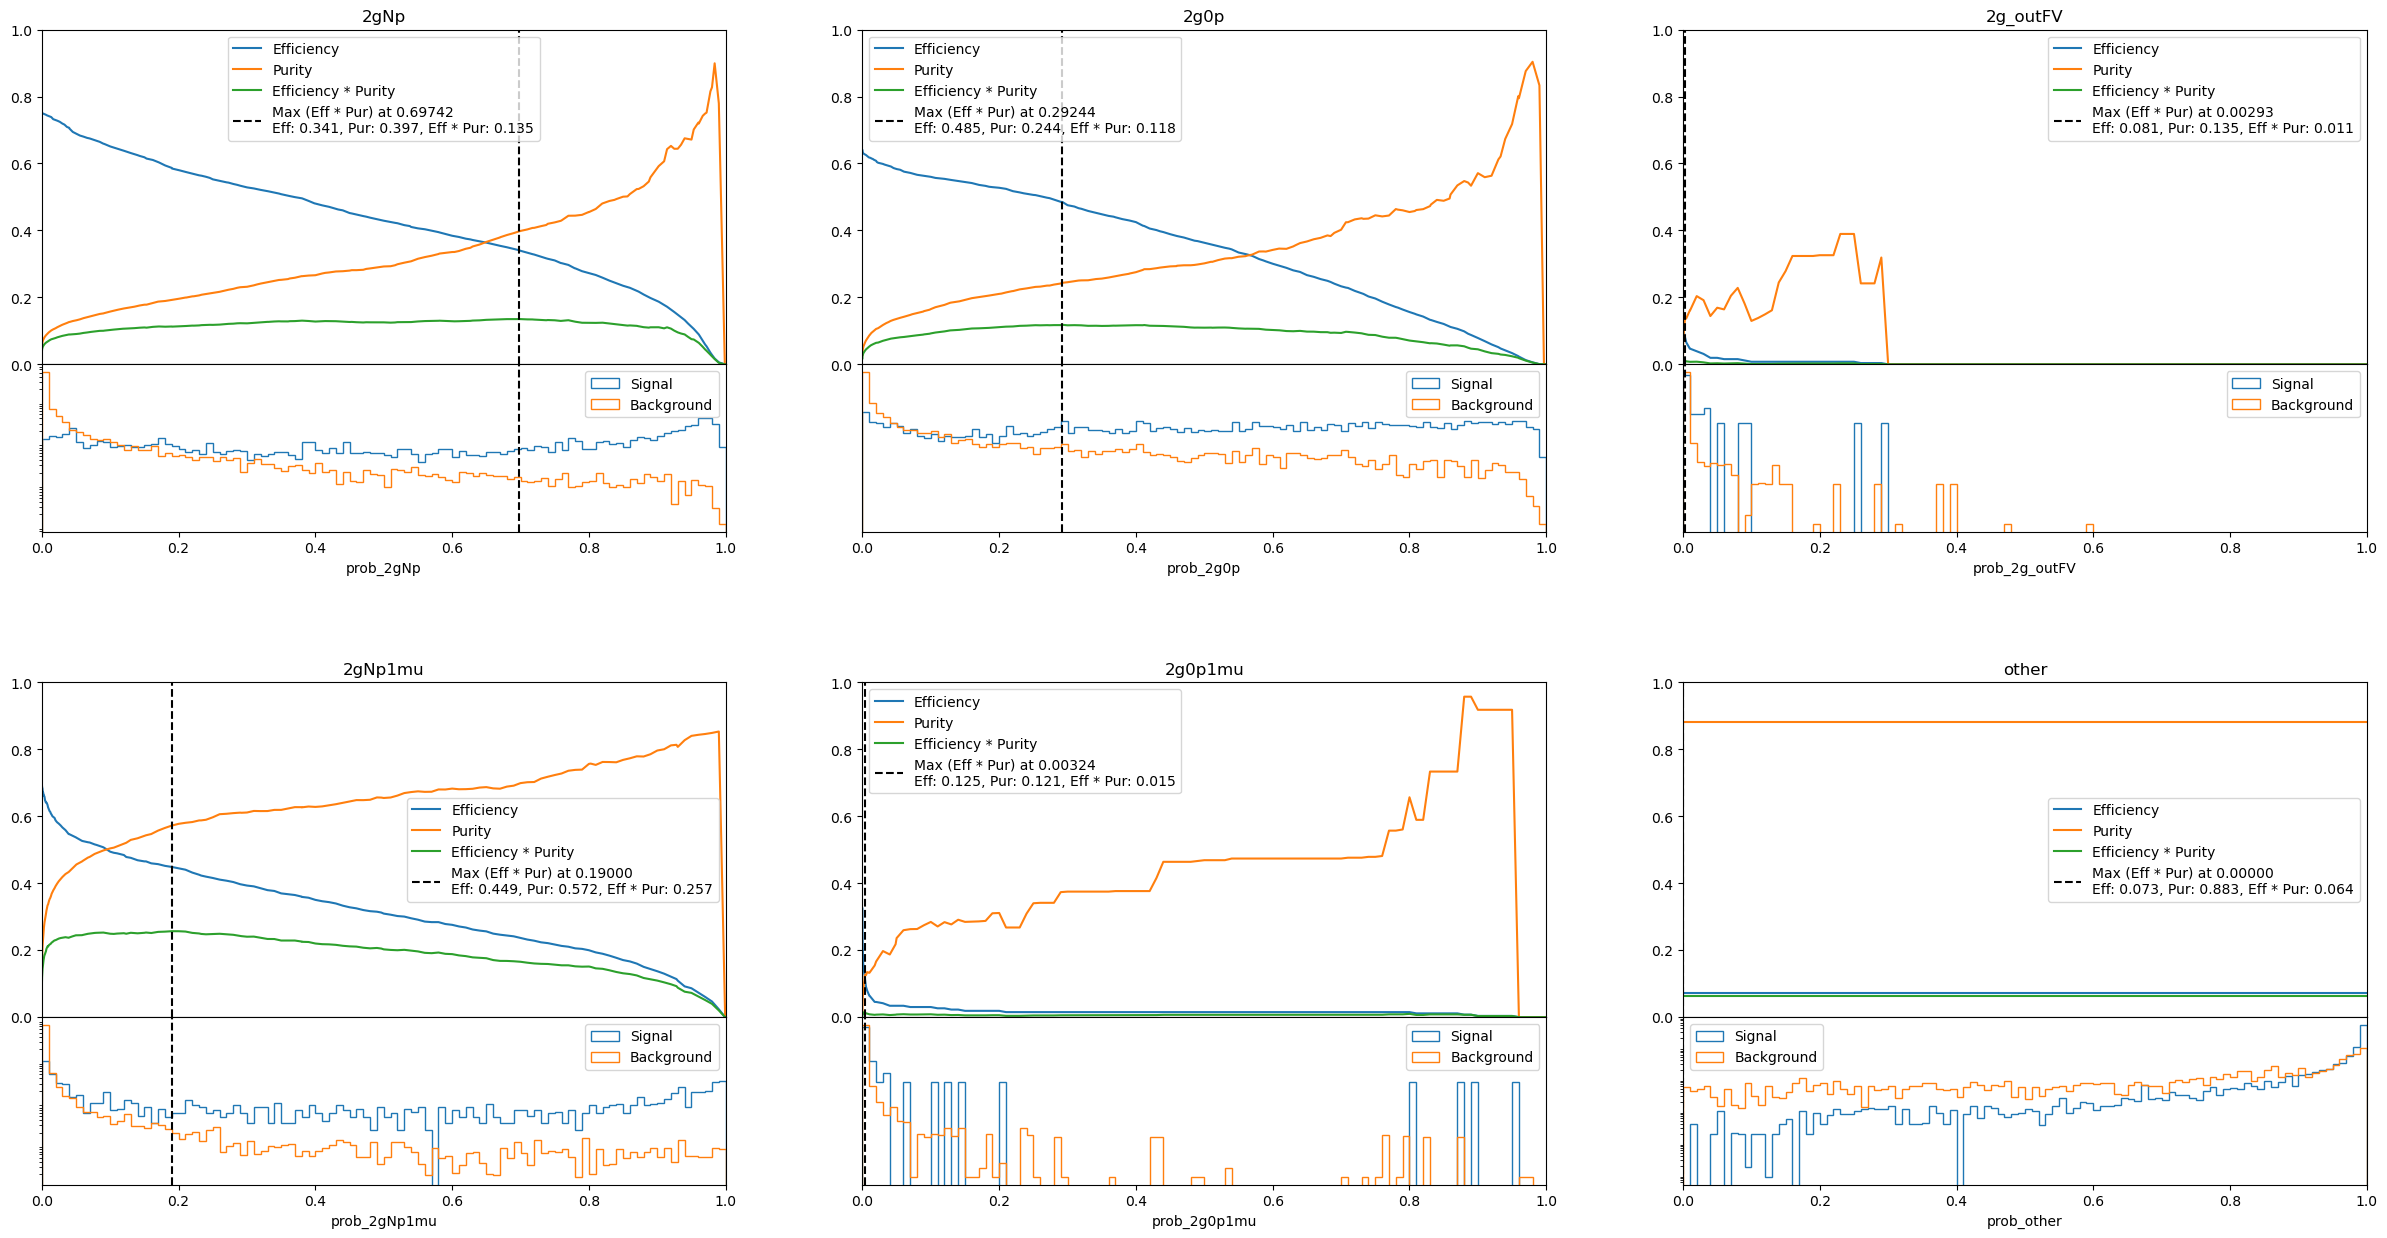

In [5]:
weights = merged_df["wc_net_weight"].to_numpy()
presel_mask = (merged_df["wc_kine_reco_Enu"] > 0) & (merged_df["wc_shw_sp_n_20mev_showers"] > 0)
sig_categories = merged_df["reconstructable_signal_category"].to_numpy()

already_selected_mask = np.zeros(merged_df.shape[0], dtype=bool)

plt.rcParams['font.size'] = 10
fig = plt.figure(figsize=(30, 15))

all_cutoffs = []

prob_types = ['prob_2gNp', 'prob_2g0p', 'prob_2gNp1mu', 'prob_2g0p1mu', 'prob_2g_outFV', 'prob_other']

for i in tqdm(range(len(prob_types))):
    prob = prob_types[i]

    signal_category = prob[5:]
    probabilities = merged_df[prob].to_numpy()
    total_sig = weights[sig_categories == signal_category].sum()

    max_eff = 0
    max_pur = 0
    max_eff_times_pur = 0
    max_eff_times_pur_cutoff = 1 # default to no selection

    all_eff = []
    all_pur = []
    all_eff_times_pur = []

    uniform_test_cutoff_points = np.linspace(0, 1, 101)
    quantile_test_cutoff_points = np.quantile(probabilities[presel_mask], np.linspace(0, 1, 101))
    test_cutoff_points = np.sort(np.concatenate([uniform_test_cutoff_points, quantile_test_cutoff_points]))

    for cutoff in test_cutoff_points:

        if signal_category == 'other':
            cutoff = 0

        sig_sel = weights[(sig_categories == prob[5:]) & presel_mask & (probabilities > cutoff) & (~already_selected_mask)].sum()
        bkg_sel = weights[(sig_categories != prob[5:]) & presel_mask & (probabilities > cutoff) & (~already_selected_mask)].sum()

        eff = sig_sel / total_sig
        if sig_sel + bkg_sel > 0:
            pur = sig_sel / (sig_sel + bkg_sel)
        else:
            pur = 0
        eff_times_pur = eff * pur

        all_eff.append(eff)
        all_pur.append(pur)
        all_eff_times_pur.append(eff_times_pur)

        num_sel_events = len(weights[presel_mask & (probabilities > cutoff) & (~already_selected_mask)])

        if eff_times_pur > max_eff_times_pur and pur > 0.02 and num_sel_events > 50: # only allow a selection with reasonable purity and enough MC stats
            max_eff = eff
            max_pur = pur
            max_eff_times_pur = eff_times_pur
            max_eff_times_pur_cutoff = cutoff

        if signal_category == 'other':
            continue


    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.2)
    reorder_indices = [0, 1, 3, 4, 2, 5]
    row = reorder_indices[i] // 3
    col = reorder_indices[i] % 3
    
    # Create nested gridspec for the two panels
    nested_gs = gs[row, col].subgridspec(2, 1, height_ratios=[2, 1], hspace=0)
    
    ax1 = fig.add_subplot(nested_gs[0])
    ax2 = fig.add_subplot(nested_gs[1])

    # Upper panel - metrics vs cutoff
    ax1.plot(test_cutoff_points, all_eff, label="Efficiency")
    ax1.plot(test_cutoff_points, all_pur, label="Purity")
    ax1.plot(test_cutoff_points, all_eff_times_pur, label="Efficiency * Purity")
    ax1.axvline(x=max_eff_times_pur_cutoff, color="k", linestyle='--', label=f"Max (Eff * Pur) at {max_eff_times_pur_cutoff:.5f}\nEff: {max_eff:.3f}, Pur: {max_pur:.3f}, Eff * Pur: {max_eff_times_pur:.3f}")
    ax1.legend()
    ax1.set_title(f"{signal_category}")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xticks([])

    # Lower panel - probability distributions
    sig_mask = (sig_categories == signal_category) & (~already_selected_mask)
    bkg_mask = ~sig_mask & (~already_selected_mask)
    
    sig_probs = probabilities[sig_mask & presel_mask & (probabilities > 0)]
    bkg_probs = probabilities[bkg_mask & presel_mask & (probabilities > 0)]
    sig_weights = weights[sig_mask & presel_mask & (probabilities > 0)]
    bkg_weights = weights[bkg_mask & presel_mask & (probabilities > 0)]

    bins = np.linspace(0, 1, 101)
    ax2.hist(sig_probs, bins=bins, weights=sig_weights, histtype='step', label='Signal', density=True)
    ax2.hist(bkg_probs, bins=bins, weights=bkg_weights, histtype='step', label='Background', density=True)
    ax2.axvline(x=max_eff_times_pur_cutoff, color="k", linestyle='--')
    ax2.legend()
    ax2.set_yscale('log')
    ax2.set_xlabel(prob)
    ax2.set_xlim(0, 1)
    ax2.set_yticks([])

    already_selected_mask[probabilities > max_eff_times_pur_cutoff] = True

    all_cutoffs.append(max_eff_times_pur_cutoff)

plt.show()

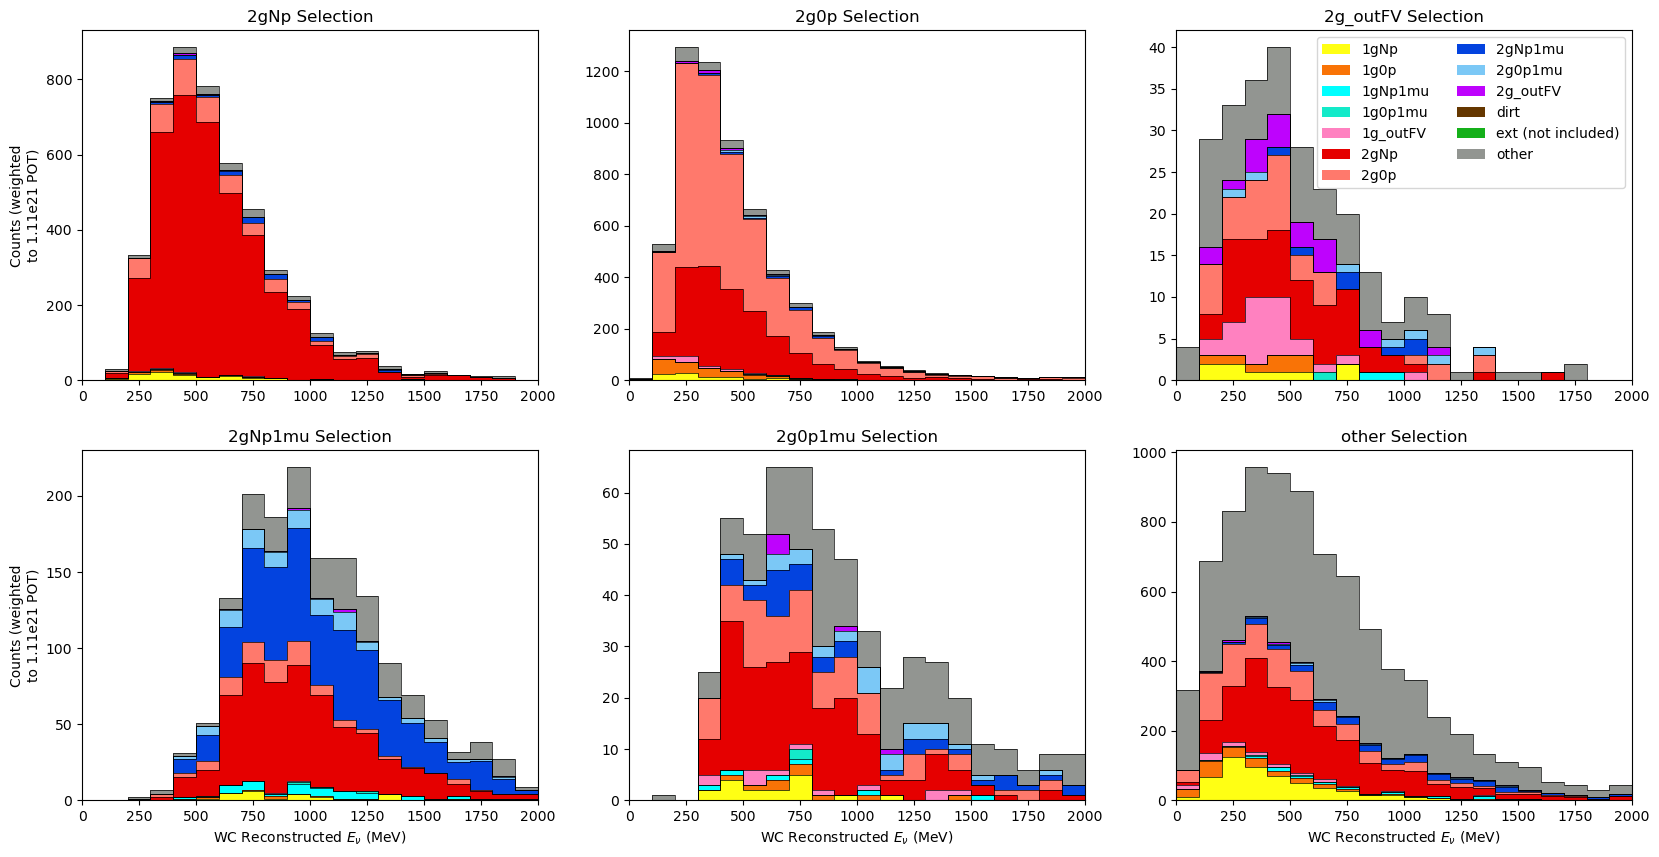

In [6]:
simple_queries = []
for i, signal_category in enumerate(['2gNp', '2g0p', '2gNp1mu', '2g0p1mu', '2g_outFV', 'other']):
    simple_queries.append(f"prob_{signal_category} > {all_cutoffs[i]:.5f}")

queries = []
for i in range(len(simple_queries)):
    if i == 0:
        queries.append(f"{simple_queries[0]}")
    else:
        queries.append(f"{simple_queries[i]} and {queries[-1].replace('>', '<')}")


breakdown_dic = {
    '1gNp': "xkcd:yellow",
    '1g0p': "xkcd:orange", 
    '1gNp1mu': "xkcd:cyan",
    '1g0p1mu': "xkcd:aqua",
    '1g_outFV': "xkcd:pink",
    '2gNp': "xkcd:red",
    '2g0p': "xkcd:salmon",
    '2gNp1mu': "xkcd:blue",
    '2g0p1mu': "xkcd:lightblue",
    '2g_outFV': "xkcd:bright purple",
    'dirt': "xkcd:brown",
    'ext (not included)': "xkcd:green",
    'other': "xkcd:gray",
}

breakdown_labels = list(breakdown_dic.keys())
colors = list(breakdown_dic.values())

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flatten()
reordered_axs = [axs[0], axs[1], axs[3], axs[4], axs[2], axs[5]]

bins = np.linspace(0, 2000, 21)
bin_centers = (bins[:-1] + bins[1:]) / 2
multi_bin_centers = [bin_centers] * len(breakdown_dic)
outline_colors = ["k"] * len(breakdown_dic)

for i, signal_category in enumerate(['2gNp', '2g0p', '2gNp1mu', '2g0p1mu', '2g_outFV', 'other']):

    sel_df = presel_merged_df.query(queries[i])

    counts = []
    for k in breakdown_dic:
        if k == 'dirt':
            curr_df = sel_df.query(f"filetype == 'dirt'")
        elif k == 'ext (not included)':
            curr_df = sel_df.query(f"filetype == 'ext'")
        elif k in ["1gNp", "1g0p", "1gNp1mu", "1g0p1mu", "2gNp", "2g0p", "2gNp1mu", "2g0p1mu", "1g_outFV", "2g_outFV", "other"]:
            curr_df = sel_df.query(f"filetype != 'dirt' and filetype != 'ext' and reconstructable_signal_category == '{k}'")
        else:
            raise ValueError(f"Invalid signal category: {k}")
        counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], bins=bins)[0])

    reordered_axs[i].hist(multi_bin_centers, weights=counts, bins=bins, color=colors, stacked=True, label=breakdown_labels)
    reordered_axs[i].hist(multi_bin_centers, weights=counts, bins=bins, color=outline_colors, histtype="step", lw=0.5, stacked=True)
    
    if i >= 3: # Only show x-label for bottom row
        axs[i].set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
    if i % 3 == 0: # Only show y-label for leftmost column
        axs[i].set_ylabel("Counts (weighted\nto 1.11e21 POT)")
    reordered_axs[i].set_title(f"{signal_category} Selection")
    axs[i].set_xlim(0, 2000)
    
    if i == 4:
        reordered_axs[i].legend(ncol=2, loc='upper right')

fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.show()

